test_x_to_s: passed


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

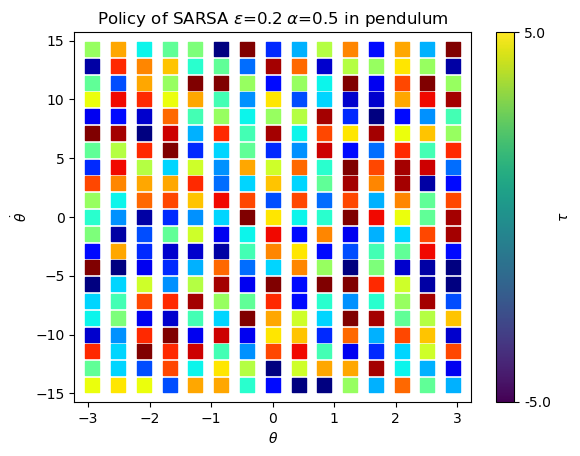

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

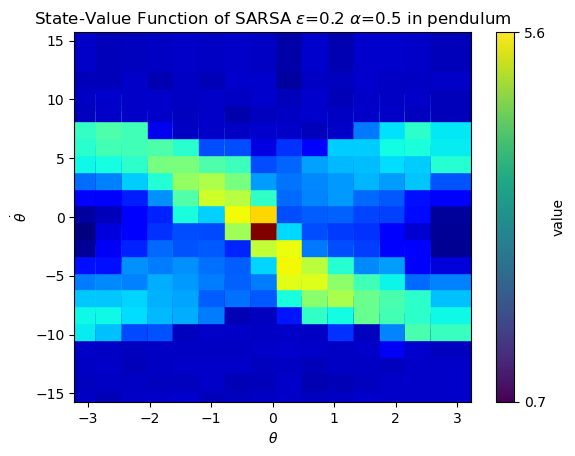

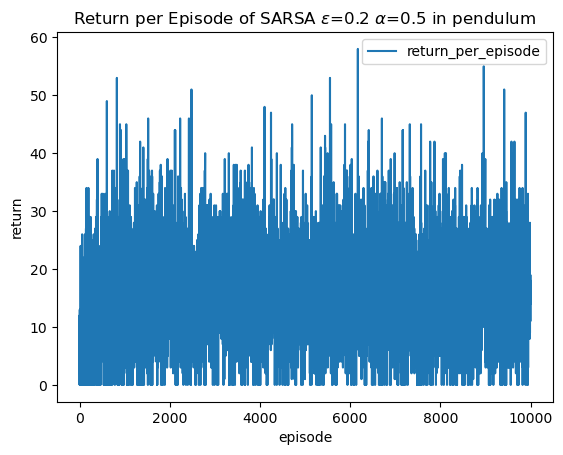

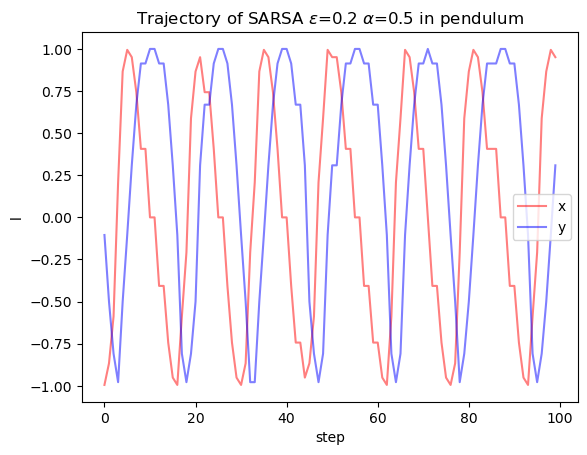

Total reward:  17


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

[[0.01987652 0.28327506 0.47172525 ... 0.07588801 0.40264282 0.78432416]
 [0.33056542 0.91665372 0.45972341 ... 0.10009773 0.31545298 0.3687812 ]
 [0.11746453 0.85848273 0.01990783 ... 0.81078029 0.96414668 0.70995587]
 ...
 [0.32392661 0.87306202 0.21609045 ... 0.84054769 0.9362528  0.45384151]
 [0.77339099 0.20211887 0.91581771 ... 0.83484726 0.86155709 0.98497627]
 [0.28156042 0.67642863 0.26404902 ... 0.17666563 0.84167262 0.97072975]]
[13 24 29  1  7  9  6  5 14  3  1 13 26 16 24 28 11  0 29 10  4 18 24 14
 30 29 10 21  7  4  5  2  7 30 29 18  5 16 30 11  8 21 13 11 30  2  5 25
 22  7  4  3  7 18 26 29 18  0 17  2 17 13 25 17 29  0 19 19 20 17  3  0
 11 10 14 16  4 17  9 30  0  3  1  2 19 17  3 26 14 26 24 27  3  0  0 18
 30  7 14  3  9 21 14  8 11  5 11 17  6 30  2 28  3 20  1 12 30 14  1  5
 10 19  4 23 13 29 25  0 27 19 29 26 27  0  1 13 21 14  7  5 11  9 19 22
 22 27 15 18  9  5  7 14 29 26 15 29 18 24  1 13  5 10 13  2  8 15  7 25
 19 27  4  1  7 10 19 21 17  6  2 28 24  6 26

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

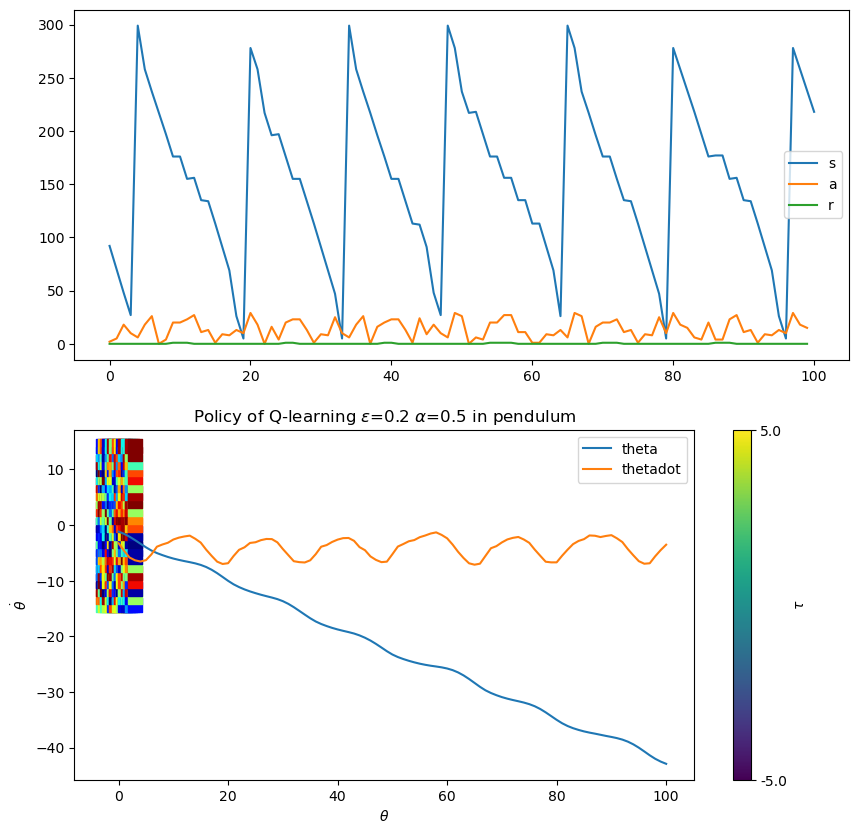

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

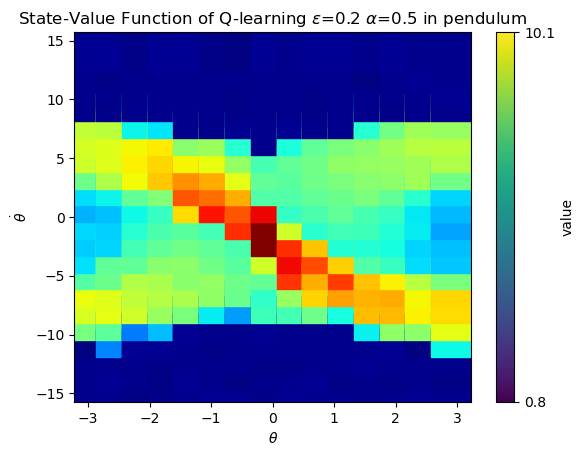

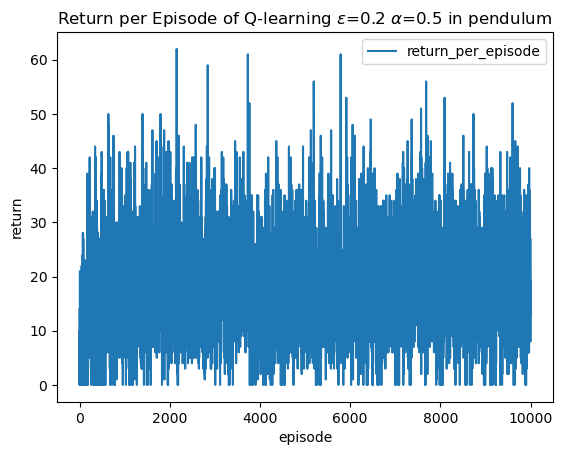

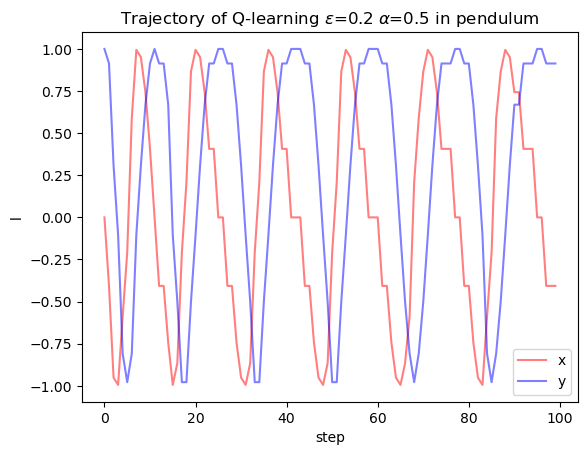

Total reward:  19


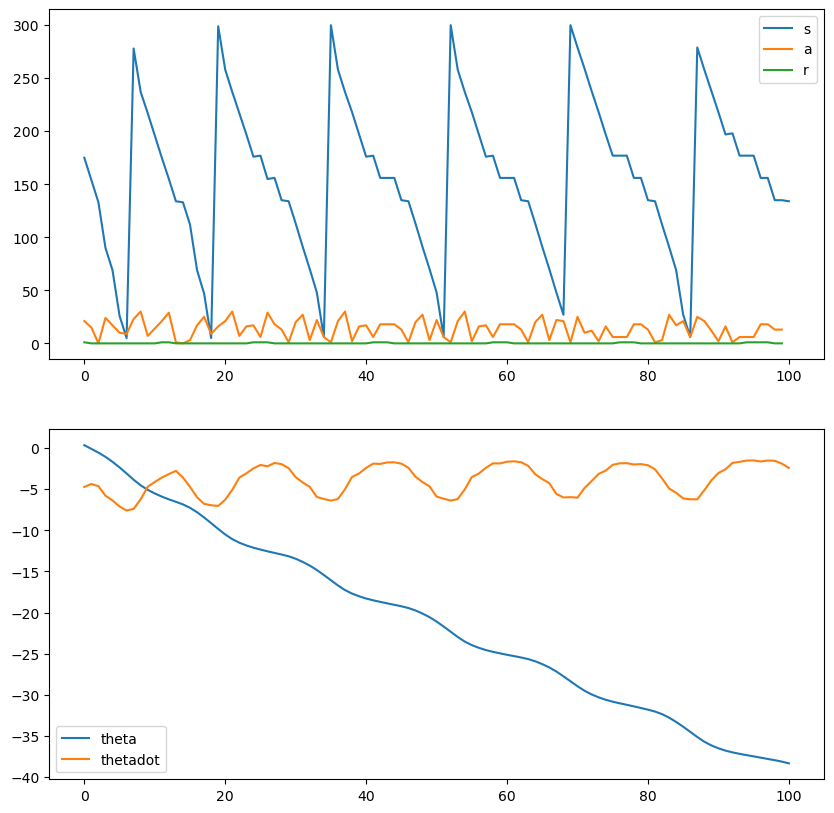

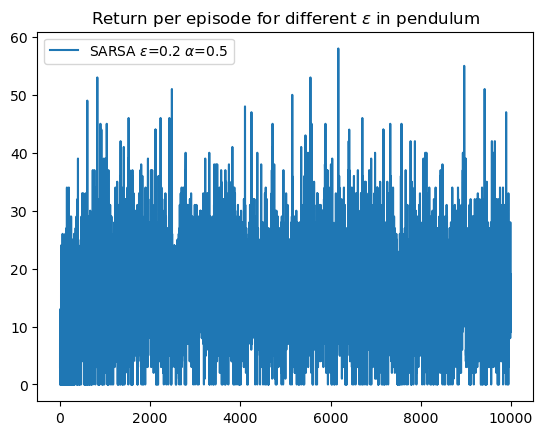

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


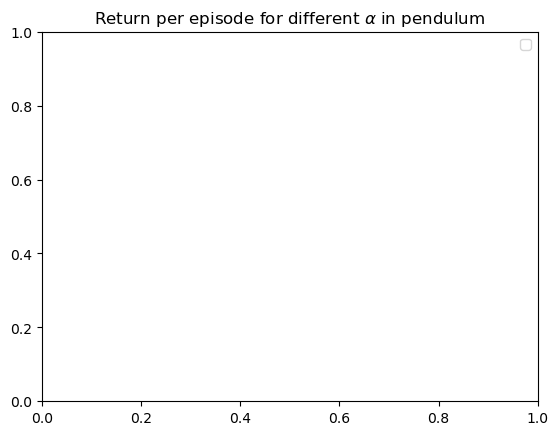

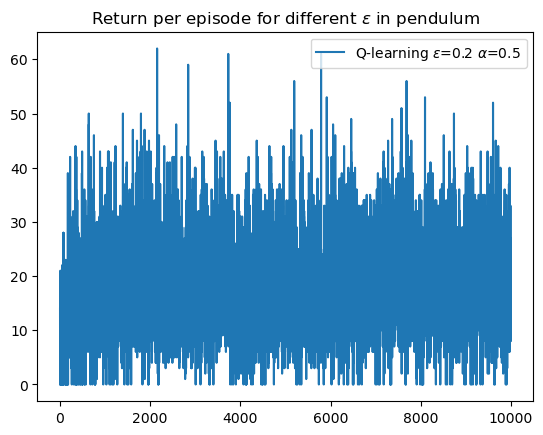

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


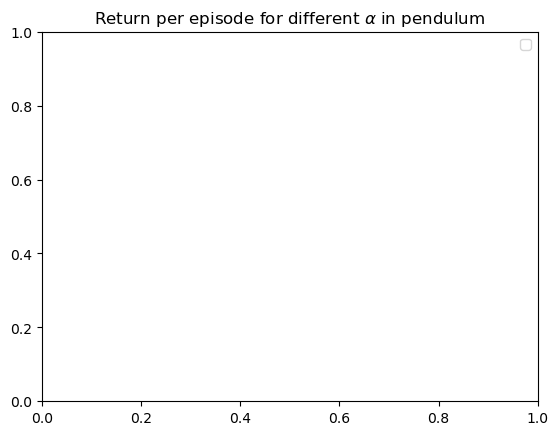

In [1]:
import matplotlib.pyplot as plt
import gridworld
import discrete_pendulum
from utils import get_learn_function
from models.plot import Plot
import numpy as np


def test_x_to_s(env):
    theta = np.linspace(-np.pi * (1 - (1 / env.n_theta)), np.pi * (1 - (1 / env.n_theta)), env.n_theta)
    thetadot = np.linspace(-env.max_thetadot * (1 - (1 / env.n_thetadot)), env.max_thetadot * (1 - (1 / env.n_thetadot)), env.n_thetadot)
    for s in range(env.num_states):
        i = s // env.n_thetadot
        j = s % env.n_thetadot
        s1 = env._x_to_s([theta[i], thetadot[j]])
        if s1 != s:
            raise Exception(f'test_x_to_s: error in state representation: {s} and {s1} should be the same')
    print('test_x_to_s: passed')

algorithms_for_scenes = {
    # 'gridworld': ['sarsa', 'q_learning', 'policy_iteration', 'value_iteration'],
    'pendulum': ['sarsa', 'q_learning']}
max_it_n = {'sarsa': 10000, 'q_learning': 10000, 'policy_iteration': 200, 'value_iteration': 200}
epsilon_fixed = 0.3
alpha_fixed = 0.4
# epsilon_n = [0.1, 0.2, 0.3, 0.4, epsilon_fixed, epsilon_fixed, epsilon_fixed, epsilon_fixed]
# alpha_n = [alpha_fixed, alpha_fixed, alpha_fixed, alpha_fixed, 0.3, 0.4, 0.5, 0.6]
epsilon_n = [epsilon_fixed]
alpha_n = [alpha_fixed]

load_checkpoint = False
train = True

for scene, algorithms in algorithms_for_scenes.items():
    # Create environment
    env = gridworld.GridWorld(hard_version=False) if scene == 'gridworld' else discrete_pendulum.Pendulum(n_theta=15, n_thetadot=21)

    if scene=='pendulum':
        test_x_to_s(env)

    for alg in algorithms:
        max_it = max_it_n[alg]
        if alg == 'sarsa' or alg == 'q_learning':
            epsilon = epsilon_n
            alpha = alpha_n
        else:
            epsilon = [0]
            alpha = [0]

        for eps, alp in zip(epsilon, alpha):
            env.reset()
            learn = get_learn_function(alg=alg)
            checkpoint = 'ckp' if load_checkpoint else None
            model = learn(env, scene=scene, epsilon=eps, alpha=alp, max_it=max_it, load=checkpoint, train=train)
            model.save_checkpoint('ckp')

            # Initialize simulation
            s = env.reset()

            # Create log to store data from simulation
            if scene == 'gridworld':
                log = {
                    't': [0],
                    's': [s],
                    'a': [],
                    'r': [],
                }
            else:
                log = {
                    't': [0],
                    's': [s],
                    'a': [],
                    'r': [],
                    'theta': [env.x[0]],        # agent does not have access to this, but helpful for display
                    'thetadot': [env.x[1]],     # agent does not have access to this, but helpful for display
                }


            # Simulate until episode is done
            done = False

            while not done:
                a = model.get_policy(s)
                (s, r, done) = env.step(a)
                log['t'].append(log['t'][-1] + 1)
                log['s'].append(s)
                log['a'].append(a)
                log['r'].append(r)
                if scene == 'pendulum':
                    log['theta'].append(env.x[0])
                    log['thetadot'].append(env.x[1])

                model.plot.add('trajectory', env.get_pos(s), 'trajectory', alpha=0.5,
                               title='Trajectory of ' + model.algorithm + ' in ' + scene, xlabel='step', ylabel='l')

            model.plot.plot_policy(model.get_policy(), save=True)
            model.plot.plot_state_value_function(model.get_state_value_function(), save=True)
            model.plot.plot(save=True)

            if scene=='gridworld':
                # Plot data and save to png file
                plt.plot(log['t'], log['s'])
                plt.plot(log['t'][:-1], log['a'])
                plt.plot(log['t'][:-1], log['r'])
                plt.legend(['s', 'a', 'r'])
                plt.savefig('figures/gridworld/test_gridworld.png')
                plt.show()
            else:
                # Plot data and save to png file
                fig, ax = plt.subplots(2, 1, figsize=(10, 10))
                ax[0].plot(log['t'], log['s'])
                ax[0].plot(log['t'][:-1], log['a'])
                ax[0].plot(log['t'][:-1], log['r'])
                ax[0].legend(['s', 'a', 'r'])
                ax[1].plot(log['t'], log['theta'])
                ax[1].plot(log['t'], log['thetadot'])
                ax[1].legend(['theta', 'thetadot'])
                plt.savefig('figures/pendulum/test_discrete_pendulum.png')
                plt.show()

            print('Total reward: ', sum(log['r']))

    algorithms = []
    n_epsilon = 4

    from models.base_model import ModelFreeAlg
    from models.sarsa.sarsa_learner import SARSA
    from models.q_learning.q_learning_learner import QLearning

    for alg in [SARSA.alg_type, QLearning.alg_type]:
        algorithms = []
        for epsilon, alpha in zip(epsilon_n, alpha_n):
            algorithms.append(ModelFreeAlg.get_model_free_alg_name([epsilon, alpha, alg]))
        Plot.plot_compare([scene for _ in range(n_epsilon)], algorithms[:n_epsilon], key='return_per_episode',
                          title=r'Return per episode for different $\epsilon$ in ' + scene, save=True,
                          plot_interval=False)
        Plot.plot_compare([scene for _ in range(len(algorithms) - n_epsilon)], algorithms[n_epsilon:],
                          key='return_per_episode',
                          title=r'Return per episode for different $\alpha$ in ' + scene, save=True,
                          plot_interval=False)

    Plot.save_all_plots('figures/data')